In [33]:
import pandas as pd
import numpy as np
import nltk
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import contractions
from contractions import contractions_dict
contractions.add("n't", "not")
contractions.add("nt", "not")
import string
punctuation_string = string.punctuation
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time as t
import sklearn.metrics as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

Open and view dataset

In [35]:
df = pd.read_csv('Datasetjson_small.csv', low_memory=False)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28028 entries, 0 to 28027
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         28028 non-null  float64
 1   vote            4509 non-null   object 
 2   verified        28028 non-null  bool   
 3   reviewTime      28028 non-null  object 
 4   reviewerID      28028 non-null  object 
 5   asin            28028 non-null  object 
 6   reviewerName    28026 non-null  object 
 7   reviewText      28018 non-null  object 
 8   summary         28020 non-null  object 
 9   unixReviewTime  28028 non-null  int64  
 10  style           17471 non-null  object 
 11  image           317 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 2.4+ MB


Create review dataset
- combine summary and review text
- calculate polarity based on review score (4,5 = positive (1) ; 3 = neutral (0) ; 1,2 = negative (-1))
- equalise number of reviews for each polarity/label
- create dataframe of relevant data only - review and polarity

In [37]:
#combine summary and review text
df['review'] = df['reviewText']+' '+df['summary']
df['review'].head()

0    I bought two of these 8.5 fl oz hand cream, an...
1    Believe me, over the years I have tried many, ...
2                         Great hand lotion Five Stars
3    This is the best for the severely dry skin on ...
4    The best non- oily hand cream ever. It heals o...
Name: review, dtype: object

In [38]:
#calculate polarity
df['polarity'] = np.where((df['overall']>3), 1,
                                np.where((df['overall']==3), 0,
                                         -1))

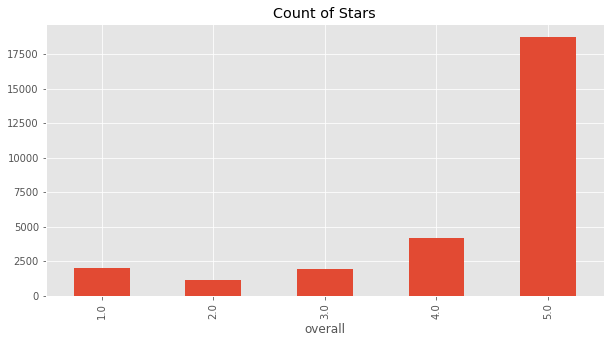

In [39]:
#plot showing distribution of review scores
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Stars',
          figsize=(10, 5))
ax.set_xlabel('overall')
plt.show()

In [40]:
#equalise number of reviews
chop = min(len((df[df['polarity']==0])), len((df[df['polarity']==-1]))) #there are always many more positive reviews
df_pos = df[df['polarity']==1].head(chop)
df_neg = df[df['polarity']==-1].head(chop)
df_neut = df[df['polarity']==0].head(chop)
df_new = pd.concat([df_pos, df_neg, df_neut])
df_new = df_new.sample(frac=1, random_state=1).reset_index(drop=True)

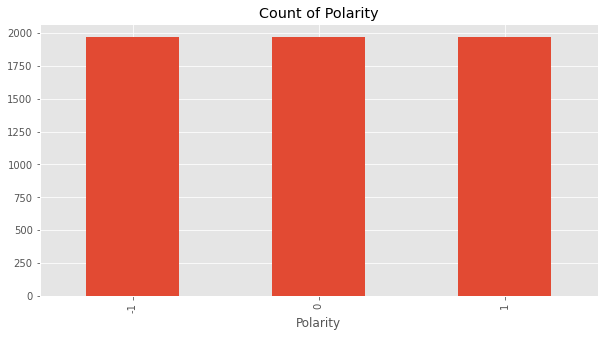

In [41]:
ax = df_new['polarity'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Polarity',
          figsize=(10, 5))
ax.set_xlabel('Polarity')
plt.show()

In [42]:
df1 = df_new[['review','polarity']]
df1.head()

,review,polarity
0,I received a $50 gift card for my birthday. Tw...,-1
1,I opened the box and quickly noticed that the ...,-1
2,In this installment of Corduroy's adventures w...,1
3,Great vacuum. Wish the suction was stronger. F...,1
4,Is very small. Doesn't fit my smokes... Way t...,-1


In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    5911 non-null   object
 1   polarity  5913 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.5+ KB


What products are reviewed the most?

In [44]:
df_meta = pd.read_csv('meta.csv')

In [46]:
df_meta.tail()

,brand,asin,category
14751099,NaN,B01GMFJ8JU,"['Gift Cards', 'Gift Cards']"
14751100,QuickGifts,B01GOQIKRI,"['Gift Cards', 'Gift Cards']"
14751101,QuickGifts,B01GOQHGL4,"['Gift Cards', 'Gift Cards']"
14751102,Go Play Golf by Fairway Rewards,B01GP1W4LA,"['Gift Cards', 'Gift Cards']"
14751103,NaN,B01H5PPJT4,"['Gift Cards', 'Gift Cards']"


In [47]:
df_merge = df.merge(df_meta, left_on='asin', right_on='asin')

In [68]:
df_merge[df_merge.brand.notnull()].groupby('brand').count().sort_values(by='reviewText', ascending=False)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,review,polarity,category
brand,,,,,,,,,,,,,,,
Holmes,1290,54,1290,1290,1290,1290,1290,1290,1290,1290,794,10,1290,1290,1290
Yat Ming,1170,162,1170,1170,1170,1170,1170,1170,1170,1170,1158,0,1170,1170,1170
Visit Amazon's Zondervan Page,828,121,828,828,828,828,828,828,827,828,828,13,827,828,828
nobrand,824,149,824,824,824,824,824,824,824,824,531,6,824,824,824
Microsoft,772,136,772,772,772,772,772,772,772,772,0,4,772,772,772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
David Garibaldi,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
Sheryl L. Roush,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
Sunbeam,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1


Text cleaning and preprocessing
- drop nulls (dropna)
- drop null reviews (notnull)
- create nltk_texts_original column to be able to query later
- drop duplicates
- make all lower case
- remove stopwords
- expand contractions
- clean punctuations (could consider replacing it with a particular letter)
- remove numbers (could consider replacing it with a particular letter)
- lemmatize - split this into loops of 100000 at a time

In [77]:
#functions

def stopwords_remove(data):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = word_tokenize(data)
    return ' '.join([w for w in tokens if not w in stop_words])

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuation_string)
    return text.translate(translator)

In [78]:
#pipeline

df1 = df1.dropna().reset_index(drop=True)
df2 = df1[df1['review'].notnull()]
print('creating nltk.Text')
nltk_col = df2.review.progress_apply(lambda row: nltk.Text(row.split(' ')))
df2=df2.assign(nltk_texts=nltk_col)
df3 = df2.drop_duplicates(subset=['review'])
lower_col = df3['review'].str.lower().copy()
df3 = df3.assign(review=lower_col)
print('removing stopwords')
stop_removed = df3['review'].progress_apply(lambda x: stopwords_remove(x))
df3 = df3.assign(review=stop_removed)
print('expanding contractions')
index_replace = df3[df3.review.str.contains('|'.join(contractions_dict.keys()), regex=True)].index
uncontracted = df3['review']
uncontracted.loc[index_replace].progress_apply(lambda x: contractions.fix(x))
df3= df3.assign(review=uncontracted)
print('cleaning punctuations')
clean_punct = df3['review'].progress_apply(lambda x: cleaning_punctuations(x))
df3 = df3.assign(review=clean_punct)
print('removing numbers')
no_numbers = df3['review'].progress_apply(lambda x: re.sub('[0-9]+','', x))
df3 = df3.assign(review=no_numbers)

creating nltk.Text


100%|██████████| 5911/5911 [00:00<00:00, 19281.46it/s]


removing stopwords


100%|██████████| 5858/5858 [00:12<00:00, 456.16it/s]


expanding contractions


100%|██████████| 1644/1644 [00:00<00:00, 12933.97it/s]


cleaning punctuations


100%|██████████| 5858/5858 [00:00<00:00, 68277.58it/s]


removing numbers


100%|██████████| 5858/5858 [00:00<00:00, 45877.82it/s]


In [79]:
#clever sizing for lemmatizer
size = len(df3)
limit = 10000

if size < limit:
    split = size
    times =1
else:
    times = int(np.ceil(size/limit))
print("loop will run ", times, " times")
count = 1
df_new = pd.DataFrame()
for i in range(0, times):
    if i ==0:
         df = df3['review'].loc[:int(limit)]
    elif i > 0 and i < times:
        print("this is loop ", i)
        df = df3['review'].loc[int(limit*(count-1)+1):int(limit*count)]
    else:
        df = df3['review'].loc[int(limit*count):]
    df_lemma = df.progress_apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
    lemma_list = df_lemma.tolist()
    count += 1
    df_new = pd.concat([df_new, df_lemma])

df_drop = df_new.drop_duplicates(subset=[0])
df3 = df3.assign(review=df_drop)
df3 = df3.dropna().reset_index(drop=True)
df3 = df3[df3['review'].notnull()]

loop will run  1  times


100%|██████████| 5858/5858 [01:00<00:00, 96.07it/s] 


Machine learning pipelines:
1. TFIDF and Bayes
- TFIDF Vectorizer
- Multinomial Bayes
2. TFIDF and Linear SVC
- TFIDF Vectorizer
- LinearSVC
3. TFIDF and SVD and Logistic Regression
- TFIDF Vectorizer
- Multinomial Bayes
4. TFIDF and Ensemble
- TFIDF Vectorizer
- Ensemble classifier - Bayes, Linear SVC, Logistic Regression

Set up data for pipeline

In [80]:
#shuffle
df3 = df3.sample(frac=1).reset_index(drop=True)
y=df3['polarity'].array
X=df3['review'].array

Create pipeline

In [81]:
# create pipeline
estimators = []
estimators.append(('vectorizer', TfidfVectorizer()))
estimators.append(('Bayes', MultinomialNB()))
model_NB = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model_NB, X, y, cv=kfold)
scoring = 'f1_macro'
cv_results = cross_val_score(model_NB, X, y, cv=kfold, scoring=scoring)
model_NB.fit(X, y)
predicted = cross_val_predict(model_NB, X, y, cv=kfold)

#results
print("cv results ", cv_results)
print(' ')
print("classification report")
print(sm.classification_report(y, predicted))
print(' ')
print("accuracy", sm.accuracy_score(y, predicted))
print(' ')
print("precision", sm.precision_score(y, predicted, average='macro'))
print(' ')
print("jaccard", sm.jaccard_score(y, predicted, average='macro'))
print(' ')
print("matthews corr", sm.matthews_corrcoef(y, predicted))
print(' ')
print("confusion matrix")
print(sm.confusion_matrix(y, predicted))

cv results  [0.82271982 0.82724104 0.79731661 0.78961031 0.80126125 0.81744531
 0.77971716 0.81545636 0.82002495 0.85266644]
 
classification report
              precision    recall  f1-score   support

          -1       0.75      0.81      0.78      1963
           0       0.80      0.69      0.74      1948
           1       0.89      0.94      0.92      1897

    accuracy                           0.81      5808
   macro avg       0.81      0.81      0.81      5808
weighted avg       0.81      0.81      0.81      5808

 
accuracy 0.8137052341597796
 
precision 0.8142170942945364
 
jaccard 0.6912924881130662
 
matthews corr 0.7223607288374329
 
confusion matrix
[[1595  268  100]
 [ 489 1342  117]
 [  41   67 1789]]


In [82]:
#Grid Search
param_grid = [
    {'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,10)], }
]
grid = GridSearchCV(estimator=model_NB, param_grid=param_grid)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

0.826101156193619
Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 10))),
                ('Bayes', MultinomialNB())])


In [83]:
# create pipeline
estimators = []
estimators.append(('vectorizer', TfidfVectorizer()))
estimators.append(('LinearSVC', LinearSVC(dual=False)))
model_SVC = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model_SVC, X, y, cv=kfold)
scoring = 'f1_macro'
cv_results = cross_val_score(model_SVC, X, y, cv=kfold, scoring=scoring)
model_SVC.fit(X, y)
predicted = cross_val_predict(model_SVC, X, y, cv=kfold)

#results
print("cv results ", cv_results)
print(' ')
print("classification report")
print(sm.classification_report(y, predicted))
print(' ')
print("accuracy", sm.accuracy_score(y, predicted))
print(' ')
print("precision", sm.precision_score(y, predicted, average='macro'))
print(' ')
print("jaccard", sm.jaccard_score(y, predicted, average='macro'))
print(' ')
print("matthews corr", sm.matthews_corrcoef(y, predicted))
print(' ')
print("confusion matrix")
print(sm.confusion_matrix(y, predicted))

cv results  [0.81830619 0.82727689 0.80822784 0.80277073 0.81795435 0.79370228
 0.78900507 0.82430401 0.82260236 0.83418977]
 
classification report
              precision    recall  f1-score   support

          -1       0.77      0.78      0.77      1963
           0       0.76      0.74      0.75      1948
           1       0.91      0.93      0.92      1897

    accuracy                           0.81      5808
   macro avg       0.81      0.81      0.81      5808
weighted avg       0.81      0.81      0.81      5808

 
accuracy 0.8137052341597796
 
precision 0.8137416786467685
 
jaccard 0.6937343256936858
 
matthews corr 0.7206074501391202
 
confusion matrix
[[1526  369   68]
 [ 405 1440  103]
 [  47   90 1760]]


In [84]:
#Grid Search
param_grid = [
    {"LinearSVC__penalty": ["l1", "l2"]},  {"LinearSVC__C": [1, 10, 100, 1000],},
    {'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,10)], }
]
grid = GridSearchCV(estimator=model_SVC, param_grid=param_grid)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

0.8300629613322243
Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('LinearSVC', LinearSVC(dual=False))])


In [85]:
# create pipeline
estimators = []
estimators.append(('vectorizer', TfidfVectorizer()))
estimators.append(('LR', LogisticRegression()))
model_LR = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model_LR, X, y, cv=kfold)
scoring = 'f1_macro'
cv_results = cross_val_score(model_LR, X, y, cv=kfold, scoring=scoring)
model_LR.fit(X, y)
predicted = cross_val_predict(model_LR, X, y, cv=kfold)

#results
print("cv results ", cv_results)
print(' ')
print("classification report")
print(sm.classification_report(y, predicted))
print(' ')
print("accuracy", sm.accuracy_score(y, predicted))
print(' ')
print("precision", sm.precision_score(y, predicted, average='macro'))
print(' ')
print("jaccard", sm.jaccard_score(y, predicted, average='macro'))
print(' ')
print("matthews corr", sm.matthews_corrcoef(y, predicted))
print(' ')
print("confusion matrix")
print(sm.confusion_matrix(y, predicted))

cv results  [0.82854327 0.83499653 0.82175122 0.80018422 0.85647203 0.79742321
 0.80465877 0.81395601 0.83689872 0.83637616]
 
classification report
              precision    recall  f1-score   support

          -1       0.78      0.80      0.79      1963
           0       0.77      0.76      0.76      1948
           1       0.93      0.91      0.92      1897

    accuracy                           0.82      5808
   macro avg       0.82      0.82      0.82      5808
weighted avg       0.82      0.82      0.82      5808

 
accuracy 0.822141873278237
 
precision 0.8241439049058829
 
jaccard 0.7061527067068932
 
matthews corr 0.733222855685471
 
confusion matrix
[[1565  343   55]
 [ 393 1480   75]
 [  57  110 1730]]


In [ ]:
# Gridsearch
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['LR__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['LR__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['LR__C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['vectorizer__ngram_range']: [(1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,10)]
# define search
search = GridSearchCV(model_LR, space, scoring='f1_macro', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/shaheedismail/Documents/A- MSc Data Science/Msc Thesis/Msc-Project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shaheedismail/Documents/A- MSc Data Science/Msc Thesis/Msc-Project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shaheedismail/Documents/A- MSc Data Science/Msc Thesis/Msc-Project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shaheedismail/Documents/A- MSc Data Science/Msc Thesis/Msc-Project/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shaheedismail/Documents/A

In [ ]:
model = LogisticRegression(solver='newton-cg')
